In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scvelo as scv

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset
from symsimDataset import SymsimBifur, SymsimTree, SymsimBranch, SymsimLinear, dyngenCircle, SymsimCycle
from unsupervised_loss import UnsupervisedLoss

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from model.autoencoder import AutoEncoder
from math import sqrt
import scprep
import utils
import backbone

from torch_geometric.data import Data

In [2]:
# dataBifur = SymsimBifur()
dataTree = SymsimTree()
# dataBranch = SymsimBranch()
# datalinear = SymsimLinear()
# dataCircle = SymsimCycle()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataTree.num_features

300

In [3]:
data = dataTree[3]
X = data.x.numpy()
# note that the dimension cannot be too small
X_pca = utils.pca_op(X, n_comps=30, standardize=False)
y = data.y.numpy().squeeze()

# Auto-encoder failed


In [46]:
from torch.utils.data import Dataset, DataLoader

class AutoEncoderDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, seg, standardize=False):

        if standardize:
            self.features = StandardScaler().fit_transform(seg['seg_features'])
        else:
            self.features = seg['seg_features']
        
        self.pseudo_time = torch.FloatTensor(seg['pseudo_time'])
        self.features = torch.FloatTensor(self.features)

    def __len__(self):
        return self.features.shape[0]

    def num_features(self):
        return self.features.shape[1]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.features[idx], self.pseudo_time[idx]

In [9]:
dataset = AutoEncoderDataset(seg, True)
dataset.num_features()

80

In [10]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [11]:
for data in dataloader:
    print(data[0].shape)
    print(data[1].shape)
    break

torch.Size([16, 80])
torch.Size([16, 20])


In [12]:
def build_reg_d(act, x, t, lambda_d, bias_t = 10):
    """
    Calculate the intracluster distances in the original data given binary-like codes.
    :param act: the codes that will be binarized and used to determine cluster assignment
    """
    # act of dimension (N, dim)
    # out of dimension (N, N)
    out = pairwise_dists(act, act)

    # same_cluster of dimension (N, N)
    same_cluster = gaussian_kernel_matrix(out)
    same_cluster = same_cluster - torch.min(same_cluster)
    same_cluster = same_cluster / torch.max(same_cluster)

    dists = pairwise_dists(x, x) + bias_t * pairwise_dists(t, t)
    dists = torch.sqrt(dists + 1e-3)

    intracluster_distances = dists * same_cluster
    intracluster_distances = torch.mean(intracluster_distances)

    loss_d = lambda_d * intracluster_distances
    return loss_d

def build_reg_c(act, lambda_c):
    """Build the tensorflow graph for the ID regularization."""
    # sum down neurons
    p = torch.sum(act, dim=0, keepdim=True)
    # normalize neuron sums
    normalized = p / torch.sum(p)

    loss_c = lambda_c * torch.sum(-normalized * torch.log(normalized + 1e-9))

    return loss_c

In [13]:
    def gaussian_kernel_matrix(dist):
        """Multi-scale RBF kernel."""
        sigmas = torch.FloatTensor([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100, 1e3, 1e4, 1e5, 1e6]).to(device)

        beta = 1. / (2. * (sigmas.unsqueeze(1)))

        s = torch.matmul(beta, dist.reshape(1, -1))

        # return torch.reshape(tf.reduce_sum(tf.exp(-s), 0), tf.shape(dist)) / len(sigmas)
        return torch.sum(torch.exp(-s), dim=0).reshape(dist.shape) / len(sigmas)

    def pairwise_dists(x1, x2):
        """Helper function to calculate pairwise distances between tensors x1 and x2."""
        r1 = torch.sum(x1 * x1, 1, keepdim=True)
        r2 = torch.sum(x2 * x2, 1, keepdim=True)

        D = r1 - 2 * torch.matmul(x1, x2.T) + r2.T

        return D

In [14]:
def train(model, train_loader, lambda_c=None, lambda_d=None, lambda_t=None, bias_t = 10):
    model.train()

    total_loss = id_loss = rmse_loss = distance_loss = time_loss = 0
    for data in dataloader:
        x, t = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        """
        Note that here I change the output of the model to incorporate the adj matrix (after the sigmoid transform)
        """
        # output = model(data)
        reconstruct, before_reconstruct, embeddings, t_reconstruct = model(x, t)

        loss = 0

        if lambda_c:
            idl = build_reg_c(before_reconstruct, lambda_c)
            loss += idl
            id_loss += idl
        
        if lambda_d:
            dl = build_reg_d(before_reconstruct, x, t, lambda_d, bias_t = bias_t)
            loss += dl 
            distance_loss += dl 

        if lambda_t:
            tl = torch.sqrt(F.mse_loss(t_reconstruct, t)) * lambda_t
            loss += tl
            time_loss += tl

        rmse = torch.sqrt(F.mse_loss(reconstruct, x))
        loss += rmse
        rmse_loss += rmse

        loss.backward()
        total_loss += loss.item()
        optimizer.step()

        n = len(dataloader.dataset)

    return float(total_loss / n), float(rmse_loss / n), float(id_loss / n), float(distance_loss / n), float(time_loss / n)

def test(model, loader):
    model.eval()
    
    correct = []
    predict = []
    for data in loader:
        data = data.to(device)
        label = data.y.detach().cpu().numpy().reshape(-1)
        
        pred,_,_ = model(data)

        pred = pred.detach().cpu().numpy().reshape(-1)
        correct.extend(label)
        predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)

    vx = predict - np.mean(predict)
    vy = correct - np.mean(correct)
    neg_pearson_loss = -np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))

    return neg_pearson_loss

In [15]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, in_channels, t_channels, latent_channels):
        super(AutoEncoder, self).__init__()

        layers = [32, 16, 8]
        # encoder
        self.lin1 = nn.Linear(in_channels, layers[0])
        self.lin2 = nn.Linear(layers[0], layers[1])
        self.lin3 = nn.Linear(layers[1], latent_channels)

        self.lin_t1 = nn.Linear(t_channels, layers[2])
        self.lin_t2 = nn.Linear(layers[2], latent_channels)
        self.lin_t3 = nn.Linear(layers[0], t_channels)

        # decoder
        self.lin4 = nn.Linear(2 * latent_channels, layers[1])
        self.lin5 = nn.Linear(layers[1], layers[0])
        self.lin6 = nn.Linear(layers[0], in_channels)

    def forward(self, x, t):
        # encode
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        t = F.relu(self.lin_t1(t))

        # embedding
        x = self.lin3(x)
        t = self.lin_t2(t)
        embeddings = torch.cat((x, t), dim=1)
        # embeddings = x

        # decode
        x = F.relu(self.lin4(embeddings))
        before_reconstruct = F.relu(self.lin5(x))
        reconstruct = self.lin6(before_reconstruct)
        t = self.lin_t3(before_reconstruct)

        return reconstruct, before_reconstruct, embeddings, t

In [21]:
# model = AutoEncoder(dataset.num_features(), 20, 5).to(device)

# reset parameters
# model.reset_parameters()
print(model)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5, weight_decay=0.05)

loss_list = []
for epoch in range(0, 201):

    loss, rmse, id, distance, time = train(model, dataloader, lambda_c=0.2, lambda_d = 0.1, lambda_t = 0.1)
    
    log = 'Epoch: {:03d}, Loss: {:.4f}, rmse: {:.4f}, id: {:.4f}, distance: {:.4f}, time: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, loss, rmse, id, distance, time))

AutoEncoder(
  (lin1): Linear(in_features=80, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=5, bias=True)
  (lin_t1): Linear(in_features=20, out_features=8, bias=True)
  (lin_t2): Linear(in_features=8, out_features=5, bias=True)
  (lin_t3): Linear(in_features=32, out_features=20, bias=True)
  (lin4): Linear(in_features=10, out_features=16, bias=True)
  (lin5): Linear(in_features=16, out_features=32, bias=True)
  (lin6): Linear(in_features=32, out_features=80, bias=True)
)
Epoch: 000, Loss: 0.0862, rmse: 0.0623, id: 0.0135, distance: 0.0078, time: 0.0027
Epoch: 010, Loss: 0.0860, rmse: 0.0624, id: 0.0130, distance: 0.0079, time: 0.0026
Epoch: 020, Loss: 0.0858, rmse: 0.0625, id: 0.0124, distance: 0.0083, time: 0.0026
Epoch: 030, Loss: 0.0853, rmse: 0.0625, id: 0.0116, distance: 0.0085, time: 0.0026
Epoch: 040, Loss: 0.0840, rmse: 0.0622, id: 0.0107, distance: 0.0085, time: 0.0026
Epoch: 050, Loss: 0

KeyboardInterrupt: 

In [22]:
def get_clusters(acts, binmin=10, max_clusters=1000, verbose=True):

    # acts of the shape (N, dim)
    acts = acts / acts.max()

    # change all non-zero into 1, binarized of the shape (N, dim)
    binarized = np.where(acts > .000001, 1, 0)

    # sample with the same binary coding (,dim) are unique, and corresponding counts are summarized
    unique_rows, counts = np.unique(binarized, axis=0, return_counts=True)
    # check the original cluster number
    print("find totally {} cluster".format(unique_rows.shape[0]))
    print("with count of samples for each cluster: ", counts)

    # eliminate clusters with small number of samples, threshold with binmin
    unique_rows = unique_rows[counts > binmin]
    print("After elimination with bmin, find totally {} cluster".format(unique_rows.shape[0]))


    # eliminated cluster number
    num_clusters = unique_rows.shape[0]

    # in case the number of clusters are too many
    if num_clusters > max_clusters:
        print("Too many clusters ({}) to go through...".format(num_clusters))
        return num_clusters, np.zeros(acts.shape[0])

    num_clusters = 0
    rows_clustered = 0
    # clusters of dimension (N,)
    clusters = -1 * np.ones(acts.shape[0])
    for i, row in enumerate(unique_rows):
        # the rows(samples) correspond to the current cluster id(binarized)
        rows_equal_to_this_code = np.where(np.all(binarized == row, axis=1))[0]

        # from 0 to all clusters number
        clusters[rows_equal_to_this_code] = num_clusters
        num_clusters += 1
        rows_clustered += rows_equal_to_this_code.shape[0]

    num_clusters = len(np.unique(clusters))
    return num_clusters, clusters

find totally 38 cluster
with count of samples for each cluster:  [  2  20  35   2  16  34   8   4  14 271  52  85   1 213  56  99   1   1
  24   6   1   1   2   1   5 214   1  15   6 100   1   1   2  44  81  11
  70   9]
After elimination with bmin, find totally 19 cluster
20


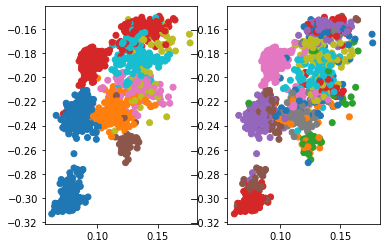

In [23]:
test_loader = DataLoader(dataset, batch_size=len(dataset))
model.eval()
fig, axs = plt.subplots(1,2)
ax1, ax2 = axs[0], axs[1]
x = []
y = []
for data in test_loader:
    x, t = data[0].to(device), data[1].to(device)
    reconstruct, before_reconstruct, embeddings, t_reconstruct = model(x, t)
    embeddings = embeddings.detach().cpu().numpy()
    reconstruct = reconstruct.detach().cpu().numpy()
    before_reconstruct = before_reconstruct.detach().cpu().numpy()

    num_clusters, clusters = get_clusters(before_reconstruct)
    print(num_clusters)
    clusters_true = seg['seg_backbone']

    ax1.scatter(embeddings[:,0], embeddings[:,1], c=clusters_true, cmap=plt.get_cmap("tab10"))
    ax2.scatter(embeddings[:,0], embeddings[:,1], c=clusters, cmap=plt.get_cmap("tab10"))

plt.show()

In [24]:
import umap
Umap = umap.UMAP(n_components = 2)
X_umap = Umap.fit_transform(np.array(seg['seg_features']))

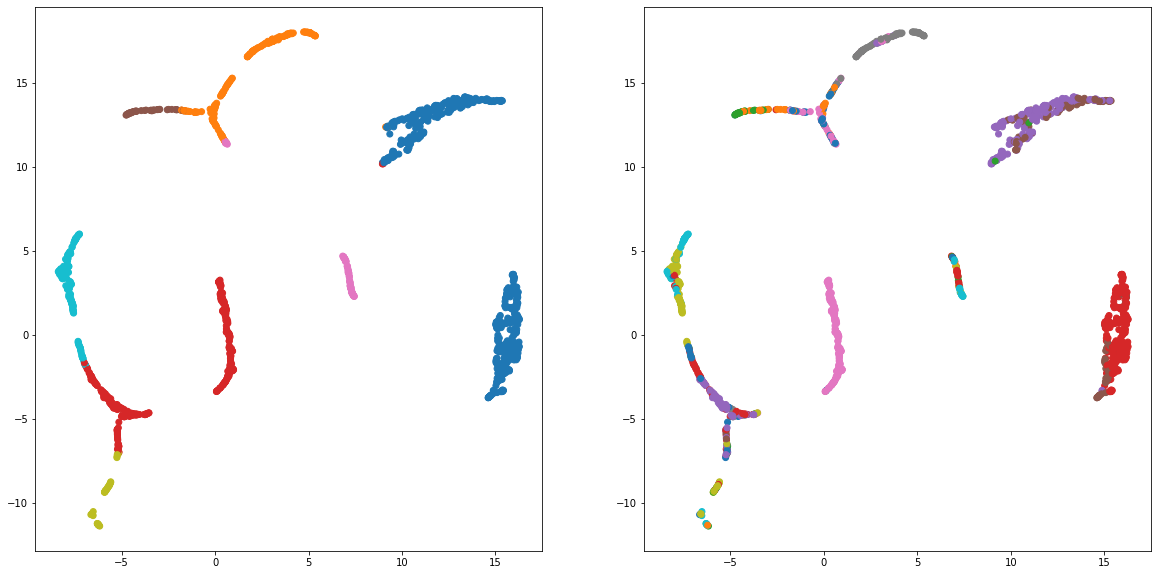

In [25]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(1,2)
ax1, ax2 = axs[0], axs[1]
ax1.scatter(X_umap[:,0], X_umap[:,1], c = clusters_true, cmap = 'tab10')
ax2.scatter(X_umap[:,0], X_umap[:,1], c=clusters, cmap = "tab10")

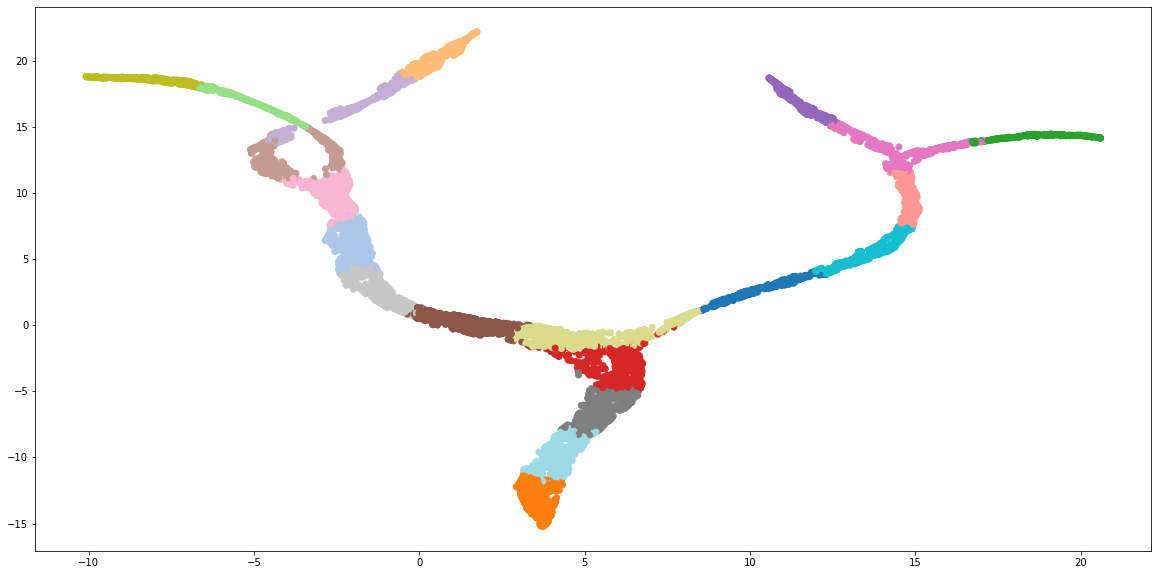

In [72]:
import umap
from sklearn.cluster import KMeans
Umap = umap.UMAP(n_components = 2)
kmeans = KMeans(n_clusters=20).fit(seg['seg_features'])
X_umap = Umap.fit_transform(np.array(seg['seg_features']))
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

ax.scatter(X_umap[:,0], X_umap[:,1], c = kmeans.labels_, cmap = 'tab20')
